a simple pytorch model for classifying the 5 types of flowers
the dataset used can be found <a href="https://www.kaggle.com/datasets/kausthubkannan/5-flower-types-classification-dataset"> here</a>

In [2]:
#importing the necassary packages
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset
from torchvision.transforms import ToTensor,Compose,Resize,Normalize
from torchvision.datasets import DatasetFolder,ImageFolder
from pathlib import Path
from torchvision import transforms
import numpy as np
from tqdm import tqdm
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt

In [3]:
image_size=(224,224)
flattened_size=image_size[0]*image_size[1]

In [4]:
#defining the model
class Model(nn.Module):
    def __init__(self,input_dim,hidden_dim,output_dim):
        super(Model,self).__init__()
        self.l1=nn.Linear(input_dim,hidden_dim)
        self.l2=nn.Linear(hidden_dim,output_dim)
    def forward(self,x): #forward propagation
        x=torch.nn.functional.relu(self.l1(x))
        x=torch.softmax(self.l2(x),dim=1)
        return x

In [5]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
device

device(type='cuda')

In [18]:
# Define the dimensions for the ImageClassifier
input_dim = 3 * flattened_size  # Adjusted input size to match the flattened image size
hidden_dim = 3
output_dim = 5
model=Model(input_dim,hidden_dim,output_dim).to(device)
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)

In [19]:
transform=Compose([
    Resize(image_size),
    ToTensor(),
    Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])
data=ImageFolder(root='/kaggle/input/5-flower-types-classification-dataset/flower_images',transform=transform)
dls=DataLoader(data,batch_size=32,shuffle=True)

In [20]:
epochs=10
model.train()
for epoch in range(epochs):
    running_loss=0.0
    progress_bar=tqdm(dls,desc=f"Epochs {epoch+1}/{epochs}",leave=False)
    for images,labels in progress_bar:
        images=images.to(device)
        labels=labels.to(device)
        resized_images=torch.nn.functional.interpolate(images,size=image_size)
        flattened_images=resized_images.view(resized_images.size(0),-1)
        outputs=model(flattened_images)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        running_loss +=loss.item()
        progress_bar.set_postfix({"loss":loss.item()})
    epoch_loss=running_loss/len(dls)
    progress_bar.set_description(f"{epoch+1}/{epochs},loss: {epoch_loss:.4f}")
    progress_bar.close()

In [21]:
model.eval()
true_labels=[]
predicted_labels=[]
with torch.no_grad():
    for images,labels in tqdm(dls):
        images=images.to(device)
        resized_images=torch.nn.functional.interpolate(images,size=image_size)
        flattened_images=resized_images.view(resized_images.size(0),-1)
        #forward prop
        outputs=model(flattened_images)
        _,predicted=torch.max(outputs,1)
        true_labels.extend(predicted.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())
true_labels=np.array(true_labels)
predicted_labels=np.array(predicted_labels)


100%|██████████| 157/157 [00:34<00:00,  4.49it/s]


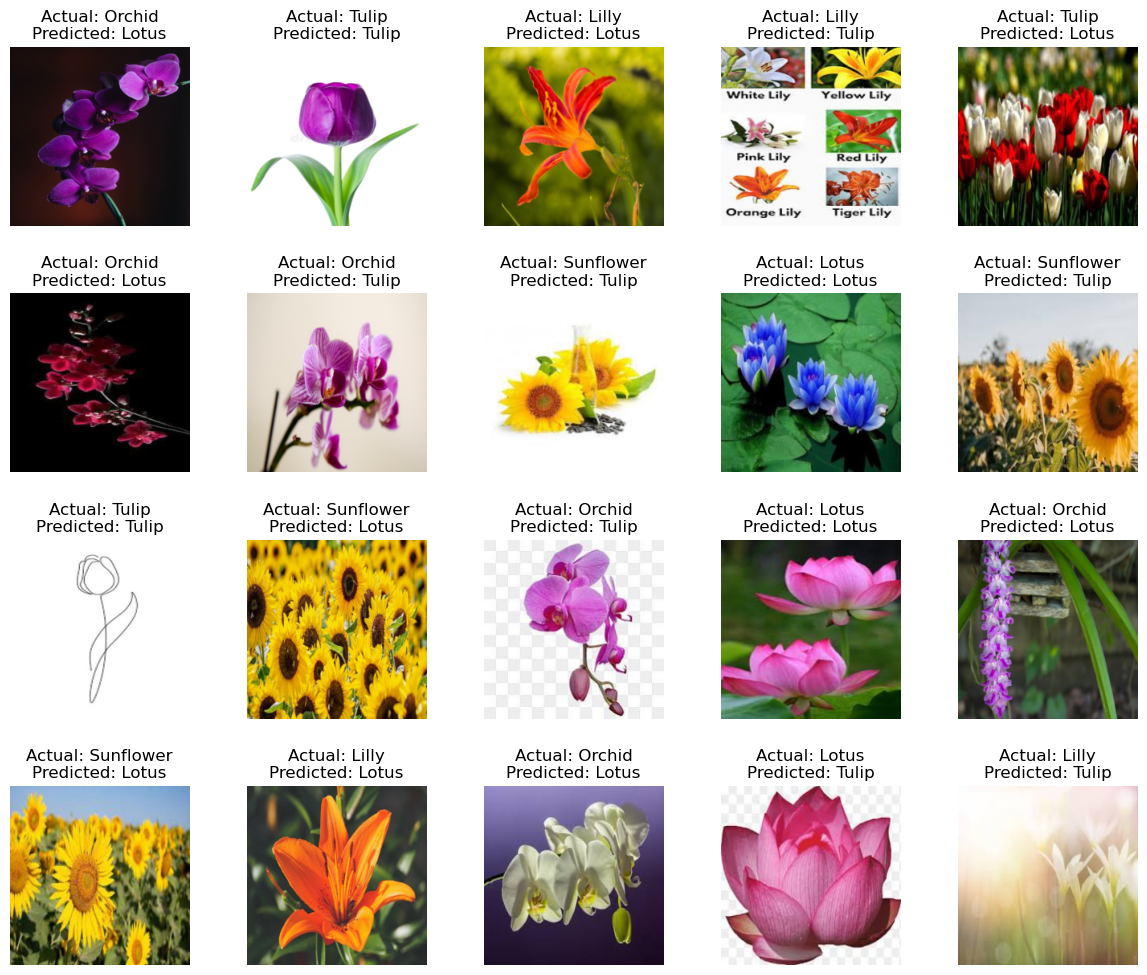

In [22]:
import matplotlib.pyplot as plt
import numpy as np

num_images = 20

test_images, test_labels = next(iter(dls))
test_images = test_images.to(device)

resized_images = torch.nn.functional.interpolate(test_images, size=image_size)
flattened_images = resized_images.view(resized_images.size(0), -1)


with torch.no_grad():
    outputs = model(flattened_images)
    _, predicted = torch.max(outputs, 1)

test_images = test_images.cpu().numpy()
test_labels = test_labels.numpy()
predicted_labels = predicted.cpu().numpy()

# Plot to display images
fig, axs = plt.subplots(4, 5, figsize=(12, 10))
fig.tight_layout()

for i in range(num_images):
    # image and true label
    image=test_images[i].transpose(1, 2, 0) / 2 + 0.5  
    true_label=data.classes[test_labels[i]]
    predicted_label=data.classes[predicted_labels[i]]

    # Plot the image with its labels
    ax = axs[i // 5, i % 5]
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(f"Actual: {true_label}\nPredicted: {predicted_label}")

plt.show()